In [1]:
from PIL import Image, ImageDraw, ImageFont
from random import randrange
from IPython.display import display
from os import listdir
import datetime
import numpy as np
import tensorflow as tf
import datetime
import random
import string
from tensorflow import keras
from keras import layers, models
from tensorflow.keras.models import load_model

In [2]:
WIDTH       =   200
HEIGHT      =   100
MINX        =    20
MINY        =    20
MAXX        =    WIDTH-60
MAXY        =    HEIGHT-60
MINSIZE     =    24
MAXSIZE     =    48
NUMCHARS    =     4 # 4 character CAPTCHA
symbol_dict = {
    "full": "0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ",
    "lower": "0123456789abcdefghijklmnopqrstuvwxyz",
    "digit": "0123456789"    
}

def onehot(symbol_set, char):
    vector = [0] * len(symbol_set)
    
    idx = symbol_set.index(char)
    vector[idx] = 1
    
    return vector

def generate_captcha(symbol_set, return_image=False):
    fonts = [i for i in filter(lambda i:i[-3:]=="ttf", listdir("fonts"))]
    charset=list(symbol_set)
    num_symbols = len(symbol_set)
    while 1:
        x_position = 0
        y_position = 0
        captcha_label = ""
        position_labels = np.array([])
        img = Image.new('RGB', (WIDTH,HEIGHT), color = (255,255,255))
        canvas = ImageDraw.Draw(img)
        for i in range(0,NUMCHARS):
            font = ImageFont.truetype(f'fonts/{fonts[randrange(len(fonts))]}', randrange(MINSIZE,MAXSIZE))
            letter = symbol_set[randrange(num_symbols)]
            x_position = x_position+randrange(0,MINX)
            y_position = randrange(MINY,40)
            position = (x_position, y_position)
            coords = canvas.textbbox(position, letter, font)
            canvas.text(position, letter, font=font, fill=(0,0,0), anchor="la")
            captcha_label = f'{captcha_label}{letter}'
            coords = [i for i in coords]
            position_labels = np.append(position_labels,coords)
            x_position = coords[2]
        x = np.array(list(img.tobytes())).reshape(WIDTH,HEIGHT,3).astype(np.float64)/255.0
        y = position_labels
        letters = list(captcha_label)
        letters = np.array([onehot(symbol_set, i) for i in letters])
#        y = [item for sublist in y for item in sublist]
#        y.extend([i for i in position_labels])
#        y = np.array(y)
        if return_image:
            yield x,(position_labels, letters[0], letters[1], letters[2], letters[3]),img
        else:
            yield x,(position_labels, letters[0], letters[1], letters[2], letters[3])

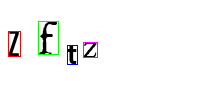

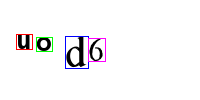

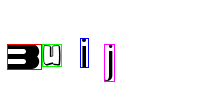

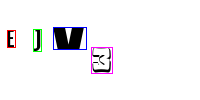

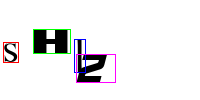

In [3]:
def draw_boxes(image, truth, predicted=[]):
    colors = [(255,0,0), (0,255,0), (0,0,255),(255,0,255), (255,255,0),(0,255,255)]
    canvas = ImageDraw.Draw(image)
    # Parse into coordinates, one for each symbol)
    coords = np.array(truth).reshape(NUMCHARS, 4)
    for color_index, box_coords in enumerate(coords):
        this_box = list(box_coords)
        canvas.rectangle(this_box, outline=colors[color_index], width=1)
    display(image)


for i in range(5):
    (x_data, y_labels, image) = next(generate_captcha(symbol_dict["lower"],return_image=True))
    draw_boxes(image, y_labels[0])

In [4]:
dataset = tf.data.Dataset.from_generator(
    lambda: generate_captcha(symbol_dict["full"], return_image=False),
    output_signature=(
        tf.TensorSpec(shape=(WIDTH, HEIGHT, 3), dtype=tf.float64),
        (
            tf.TensorSpec(shape=(16,), dtype=tf.float32)
        )
    )
)


def only_boxes(image, targets):
    """
    targets = (pos_labels, letter1, letter2, letter3, letter4)
    We only return pos_labels.
    """
    pos_labels = targets[0]
    return image, pos_labels

dataset = dataset.map(only_boxes)
dataset = dataset.batch(32)

In [5]:
PATH = './logs/Functional_Solver/'
log_dir = PATH + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

inputs = keras.Input(shape=(WIDTH, HEIGHT, 3))

x = layers.Conv2D(8, 6, activation="relu", name="Input_CNN")(inputs)
x = layers.MaxPooling2D(2, name="Pooling_1")(x)
x = layers.Conv2D(32, 3, activation="relu", name="2nd_CNN")(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.25)(x)
x = layers.Flatten()(x)

# Only keep the bounding-box head
boxes = layers.Dense(512, activation="relu")(x)
boxes = layers.Dropout(0.25)(boxes)
boxes = layers.Dense(128, activation="relu")(boxes)
boxes = layers.Dropout(0.25)(boxes)
boxes = layers.Dense(64, activation="relu")(boxes)
boxes = layers.Dense(128, activation="relu")(boxes)
box_outputs = layers.Dense(16, activation="linear", name="Bounding_Boxes")(boxes)

bbox_model = keras.Model(inputs=inputs,
                    outputs=box_outputs,
                    name="CAPTCHA_solver_only_boxes")
                    
bbox_model.compile(
    loss="mse",           # or "mae", SmoothL1, etc.
    optimizer="adam",
    metrics=[]            # "accuracy" doesn't really apply to bounding-box regression
)

In [7]:
history = model.fit(dataset, epochs=500, steps_per_epoch=50,callbacks=[tensorboard_callback])
model.save(f'bbox_model.keras')

In [6]:
bbox_model = load_model("bbox_model.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
[[ 16.87292   38.915234  35.957016  64.65114   39.791153  47.265305
   62.56617   75.20688   74.394196  44.34108   95.18058   67.61906
  109.58369   45.399143 127.93765   68.53217 ]]


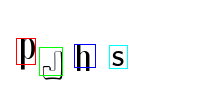

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[[ 16.586407  40.31179   57.579662  69.618286  68.34294   39.787304
   85.91784   63.394035  95.67348   35.097195 113.79521   58.38
  119.47692   42.649197 139.37143   68.61807 ]]


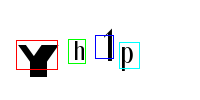

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[[ 6.6773863 44.859665  26.049562  68.49622   35.751514  33.063667
  49.074245  51.47047   59.263283  36.814445  72.37758   56.77588
  78.088295  37.89465   98.99126   63.164642 ]]


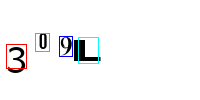

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[[ 16.053644  41.401196  38.644505  65.88386   49.07458   48.5751
   77.6227    78.141884  93.49481   36.070045 119.528534  60.891216
  133.17415   31.66903  156.6509    55.2363  ]]


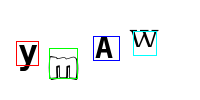

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[[  2.6453853  41.36272    26.12063    68.27886    35.01923    39.626427
   53.425213   63.46666    63.85834    42.93666    89.48847    69.92299
   99.53771    36.891914  116.87585    60.87659  ]]


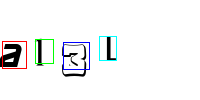

In [7]:
for i in range(0,5):
    x, (bbox, c1,c2,c3,c4), image = next(generate_captcha(symbol_dict["full"],return_image=True))
    results  = bbox_model.predict(x.reshape(-1,WIDTH,HEIGHT,3))
    print(results)
    canvas = ImageDraw.Draw(image)
    coords = results[0][0:4]
    canvas.rectangle(coords, outline=(255,0,0), width=1)
    coords = results[0][4:8]
    canvas.rectangle(coords, outline=(0,255,0), width=1)
    coords = results[0][8:12]
    canvas.rectangle(coords, outline=(0,0,255), width=1)
    coords = results[0][12:16]
    canvas.rectangle(coords, outline=(0,255,255), width=1)

    display(image)

In [8]:
def crop_characters(image, bboxes):
    """
    image: np array (HEIGHT, WIDTH, 3)
    bboxes: length-16 array [x1, y1, x2, y2, x1, y1, x2, y2, ...] for 4 chars
    
    returns: list of 4 sub-images
    """
    # Ensure bboxes is a numpy array
    bboxes = np.asarray(bboxes).ravel()  # shape (16,)
    
    crops = []
    for i in range(4):
        coords = bboxes[4*i : 4*i+4]
        crop = image.crop(coords).resize((50,50))
        crops.append(crop)
    return crops

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
[[ 16.790237  40.149345  43.068424  65.82163   52.53293   52.560017
   74.9333    80.64924   84.28807   35.70104  112.1548    63.001095
  124.81568   35.200584 152.98378   62.091423]]


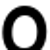

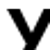

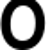

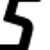

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[[ 11.505387  32.21801   28.321613  53.709564  41.378036  35.15405
   60.77679   59.08529   72.54322   56.85224   98.46374   85.940475
  103.38438   28.417805 118.14701   50.215145]]


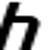

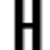

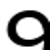

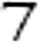

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
[[ 17.749258  39.634365  49.273182  65.406906  60.178303  37.714336
   74.33105   58.50308   81.6996    38.55674   95.69443   59.05903
   99.10072   31.94062  110.29745   51.142582]]


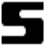

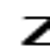

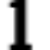

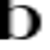

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[[ 12.401476  44.160683  25.733356  64.62267   31.687517  57.36237
   55.351784  86.792656  65.91882   31.880816  80.66435   53.315792
   87.966675  51.009426 105.893265  76.309494]]


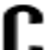

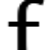

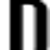

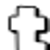

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[[  5.2900105  29.267164   31.217186   54.022892   35.570244   35.478012
   71.614876   65.04061    85.567795   45.69424   111.70323    72.435005
  121.91924    43.199203  142.73274    68.78016  ]]


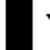

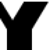

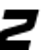

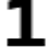

In [9]:
for i in range(0,5):
    (x, y, image) = next(generate_captcha(symbol_dict["lower"], return_image=True))
    results  = bbox_model.predict(x.reshape(-1,WIDTH,HEIGHT,3))
    print(results)
    crops = crop_characters(image, results)
    for crop in crops:
        display(crop)

In [13]:
def build_char_classifier(num_symbols, name, input_shape=(50, 50, 3)):
    inputs = keras.Input(shape=input_shape)

    x = layers.Conv2D(32, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPooling2D(pool_size=2)(x)

    x = layers.Conv2D(64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.25)(x)
    outputs = layers.Dense(num_symbols, activation="softmax")(x)

    model = keras.Model(inputs, outputs, name=name)
    return model

In [14]:
char_model_full = build_char_classifier(len(symbol_dict["full"]), "Char_Model_Full", input_shape=(50, 50, 3))
char_model_full.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

char_model_lower = build_char_classifier(len(symbol_dict["lower"]), "Char_Model_Lower", input_shape=(50, 50, 3))
char_model_lower.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

char_model_digit = build_char_classifier(len(symbol_dict["digit"]), "Char_Model_digit", input_shape=(50, 50, 3))
char_model_digit.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [23]:
def generate_char_crops_pred(symbol_set):
    """
    Generates single-character training samples based on
    *predicted* bounding boxes from our bbox_model.
    Each sample is (cropped_50x50_image_array, one_hot_label).
    """
    base_gen = generate_captcha(symbol_set, return_image=True)
    while True:
        x, (boxes_gt, c1, c2, c3, c4), image = next(base_gen)
        x_input = x[None, ...]

        pred_bboxes = bbox_model.predict(x_input)[0]

        crops = crop_characters(image, pred_bboxes)

        labels = [c1, c2, c3, c4]

        for crop, label in zip(crops, labels):
            crop = np.array(crop, dtype=np.float32)
            crop /= 255.0

            yield (crop, label)

In [24]:
dataset_crops_full_pred = tf.data.Dataset.from_generator(
    lambda: generate_char_crops_pred(symbol_dict["full"]),
    output_signature=(
        tf.TensorSpec(shape=(50, 50, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(len(symbol_dict["full"]),), dtype=tf.float32)
    )
)

dataset_crops_full_pred = dataset_crops_full_pred.batch(32)

dataset_crops_lower_pred = tf.data.Dataset.from_generator(
    lambda: generate_char_crops_pred(symbol_dict["lower"]),
    output_signature=(
        tf.TensorSpec(shape=(50, 50, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(len(symbol_dict["lower"]),), dtype=tf.float32)
    )
)

dataset_crops_lower_pred = dataset_crops_lower_pred.batch(32)

dataset_crops_digit_pred = tf.data.Dataset.from_generator(
    lambda: generate_char_crops_pred(symbol_dict["digit"]),
    output_signature=(
        tf.TensorSpec(shape=(50, 50, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(len(symbol_dict["digit"]),), dtype=tf.float32)
    )
)

dataset_crops_digit_pred = dataset_crops_digit_pred.batch(32)

In [25]:
import tensorflow as tf
from IPython.utils import io

class MinimalLogger(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.log_lines = [] 

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        msg = (f"Epoch {epoch+1} | loss: {logs.get('loss'):.4f} | "
               f"acc: {logs.get('accuracy', 0):.4f}")
        self.log_lines.append(msg)

    def get_logs(self):
        lines = "\n".join(self.log_lines)
        self.log_lines = []
        return lines


In [26]:
bbox_model = load_model("bbox_model.keras")
logger = MinimalLogger()

In [32]:
with io.capture_output() as captured:
    history = char_model_full.fit(
        dataset_crops_full_pred,
        epochs=5,
        steps_per_epoch=500,
        verbose = 2,
        callbacks=[logger]
    )
print(logger.get_logs())
char_model_full.save(f'char_model_full.keras')

Epoch 1 | loss: 0.8277 | acc: 0.7265
Epoch 2 | loss: 0.8116 | acc: 0.7318
Epoch 3 | loss: 0.7793 | acc: 0.7387
Epoch 4 | loss: 0.7778 | acc: 0.7386
Epoch 5 | loss: 0.7439 | acc: 0.7450


In [33]:
with io.capture_output() as captured:
    history = char_model_lower.fit(
        dataset_crops_lower_pred,
        epochs=5,
        steps_per_epoch=500,
        verbose = 2,
        callbacks=[logger]
    )
print(logger.get_logs())
char_model_lower.save(f'char_model_lower.keras')

Epoch 1 | loss: 0.5470 | acc: 0.8403
Epoch 2 | loss: 0.5315 | acc: 0.8441
Epoch 3 | loss: 0.4868 | acc: 0.8570
Epoch 4 | loss: 0.4722 | acc: 0.8583
Epoch 5 | loss: 0.4528 | acc: 0.8674


In [34]:
with io.capture_output() as captured:
    history = char_model_digit.fit(
        dataset_crops_digit_pred,
        epochs=5,
        steps_per_epoch=500,
        verbose = 2,
        callbacks=[logger]
    )
print(logger.get_logs())
char_model_digit.save(f'char_model_digit.keras')

Epoch 1 | loss: 0.0953 | acc: 0.9714
Epoch 2 | loss: 0.0733 | acc: 0.9796
Epoch 3 | loss: 0.0861 | acc: 0.9756
Epoch 4 | loss: 0.0764 | acc: 0.9779
Epoch 5 | loss: 0.0679 | acc: 0.9816


In [35]:
bbox_model = load_model("bbox_model.keras")
char_model_full = load_model("char_model_full.keras")
char_model_lower = load_model("char_model_lower.keras")
char_model_digit = load_model("char_model_digit.keras")
print(bbox_model)
print(char_model_full)
print(char_model_lower)
print(char_model_digit)

<Functional name=CAPTCHA_solver_only_boxes, built=True>
<Functional name=Char_Model_Full, built=True>
<Functional name=Char_Model_Lower, built=True>
<Functional name=Char_Model_digit, built=True>


In [42]:
def decode_one_hot(one_hot_vec, symbol_set):
    index = np.argmax(one_hot_vec)
    return symbol_set[index]

def captcha_string_from_onehots(labels, symbol_set):
    return "".join(decode_one_hot(l, symbol_set) for l in labels)

def predict_captcha_string(x, image, bbox_model, char_model, symbol_set):
    pred_bboxes = bbox_model.predict(x.reshape(-1,WIDTH,HEIGHT,3))

    crops = crop_characters(image, pred_bboxes)

    predicted_chars = []
    for crop in crops:
        crop = np.array(crop, dtype=np.float32)
        crop /= 255.0
        crop = crop[None, ...]
        probs = char_model.predict(crop)
        idx = np.argmax(probs)
        predicted_chars.append(symbol_set[idx])

    return "".join(predicted_chars)


In [47]:
def test_model(char_model, symbol_set):
    with io.capture_output() as captured:
        num_test = 500
        num_correct = 0
        for _ in range(num_test):
            x, (boxes, c1, c2, c3, c4), image = next(generate_captcha(symbol_set, return_image=True))
            gt_string = captcha_string_from_onehots([c1, c2, c3, c4], symbol_set)
            predicted_string = predict_captcha_string(
            x, 
            image, 
            bbox_model,
            char_model,
            symbol_set
            )
            if predicted_string == gt_string:
                num_correct += 1
    
    accuracy = num_correct / num_test
    print(f"{char_model} Captcha Accuracy: {accuracy:.2%}")

In [48]:
test_model(char_model_full, symbol_dict["full"])
test_model(char_model_lower, symbol_dict["lower"])
test_model(char_model_digit, symbol_dict["digit"])

<Functional name=Char_Model_Full, built=True> Captcha Accuracy: 37.20%
<Functional name=Char_Model_Lower, built=True> Captcha Accuracy: 67.60%
<Functional name=Char_Model_digit, built=True> Captcha Accuracy: 95.00%


<Functional name=Char_Model_Full, built=True> 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
['H', 'J', 'I', 'i']
hj1i
ERROR!! Predicted: H, Answer: h, Index: 0
ERROR!! Predicted: J, Answer: j, Index: 1
ERROR!! Predicted: I, Answer: 1, Index: 2


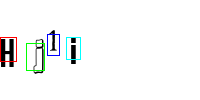

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
['G', 'k', '7', '8']
Gk78


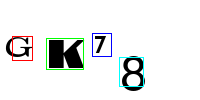

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
['x', 'i', 'H', 'r']
xiHr


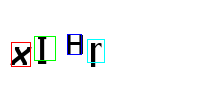

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
['8', '0', 'J', 'P']
80dP
ERROR!! Predicted: J, Answer: d, Index: 2


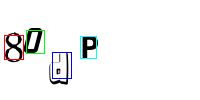

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
['S', 'd', 'O', 'k']
SdDk
ERROR!! Predicted: O, Answer: D, Index: 2


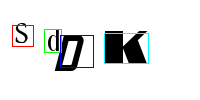

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
['j', 'O', 'i', 'T']
j0iT
ERROR!! Predicted: O, Answer: 0, Index: 1


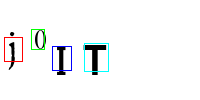

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
['O', 'M', '7', 'e']
OM7e


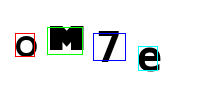

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
['A', 'p', 'i', 'f']
Apif


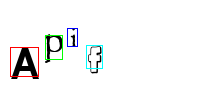

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
['D', 'u', 'J', 'a']
DuJa


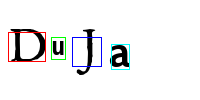

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
['m', 'e', 'k', 'V']
meKJ
ERROR!! Predicted: k, Answer: K, Index: 2
ERROR!! Predicted: V, Answer: J, Index: 3


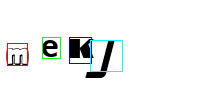

<Functional name=Char_Model_Lower, built=True> 0123456789abcdefghijklmnopqrstuvwxyz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
['6', '4', '8', '6']
9486
ERROR!! Predicted: 6, Answer: 9, Index: 0


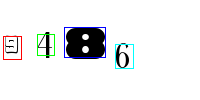

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
['s', '7', 'f', 'z']
s7fz


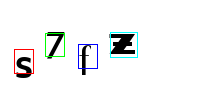

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
['3', 'n', 'v', 'b']
3nvb


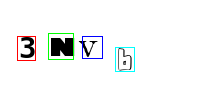

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
['p', 's', 'o', 'p']
psop


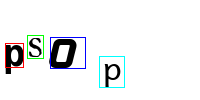

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
['5', 'y', '0', '8']
5y08


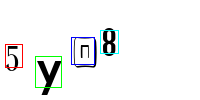

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
['9', '0', 'o', 's']
90os


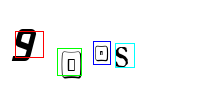

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
['q', 'j', 'l', '6']
qjl6


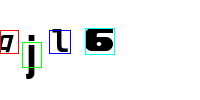

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
['c', '5', 'j', '7']
c517
ERROR!! Predicted: j, Answer: 1, Index: 2


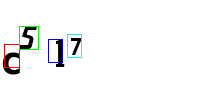

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
['l', 'v', 'd', 'q']
0vdq
ERROR!! Predicted: l, Answer: 0, Index: 0


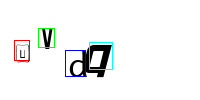

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
['r', 'm', 'h', 'd']
iahd
ERROR!! Predicted: r, Answer: i, Index: 0
ERROR!! Predicted: m, Answer: a, Index: 1


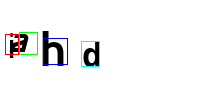

<Functional name=Char_Model_digit, built=True> 0123456789
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
['5', '0', '8', '3']
5083


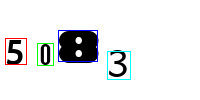

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
['8', '8', '8', '2']
8882


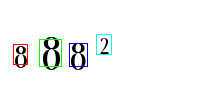

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
['9', '9', '5', '3']
9953


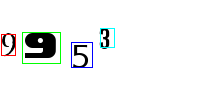

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
['3', '1', '7', '2']
3172


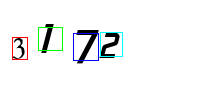

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
['4', '8', '9', '2']
4892


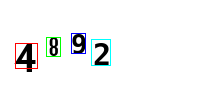

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
['2', '6', '7', '2']
2672


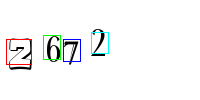

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
['6', '6', '9', '4']
6694


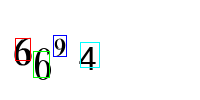

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
['7', '3', '3', '0']
7350
ERROR!! Predicted: 3, Answer: 5, Index: 2


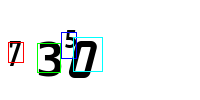

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
['1', '9', '6', '1']
1961


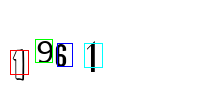

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
['5', '6', '8', '9']
5689


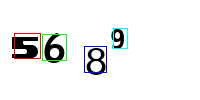

In [46]:
char_models = [char_model_full, char_model_lower, char_model_digit]
symbol_sets = [symbol_dict["full"], symbol_dict["lower"], symbol_dict["digit"]]

for char_model, symbol_set in zip(char_models, symbol_sets):
    print(char_model, symbol_set)
    for _ in range(10):
        x, (boxes_gt, c1, c2, c3, c4), image = next(generate_captcha(symbol_set, return_image=True))
        y_true = [c1,c2,c3,c4]
        pred_bboxes = bbox_model.predict(x.reshape(-1,WIDTH,HEIGHT,3))
        crops = crop_characters(image, pred_bboxes)
        predicted_chars = []
        for crop in crops:
            crop = np.array(crop, dtype=np.float32)
            crop /= 255.0
            crop = crop[None, ...]
            probs = char_model.predict(crop)
            idx = np.argmax(probs)
            
            predicted_chars.append(symbol_set[idx])
    
        canvas = ImageDraw.Draw(image)
        coords = pred_bboxes[0][0:4]
        canvas.rectangle(coords, outline=(255,0,0), width=1)
        coords = pred_bboxes[0][4:8]
        canvas.rectangle(coords, outline=(0,255,0), width=1)
        coords = pred_bboxes[0][8:12]
        canvas.rectangle(coords, outline=(0,0,255), width=1)
        coords = pred_bboxes[0][12:16]
        canvas.rectangle(coords, outline=(0,255,255), width=1)
    
        print(predicted_chars)
        answer = captcha_string_from_onehots(y_true, symbol_set)
        print(answer)
    
        for i, char in enumerate(predicted_chars):
            if char != answer[i]:
                print(f"ERROR!! Predicted: {char}, Answer: {answer[i]}, Index: {i}")
    
        display(image)
    